## Control Variables
- Resolution = 0.25
- ROBOT_RADIUS = 0.25
- NUM_OF_AGENT = 10
- ANN Samples = 100

### ANN with Optimiser

In [1]:
import BayesianOptimisation.boVoronoiDirected as boVoronoiDirected
import BayesianOptimisation.expGrid as expGrid
import BayesianOptimisation.expVoronoi as expVoronoi
import BayesianOptimisation.ANNVoronoiDirected as ANNVoronoiDirected
import BayesianOptimisation.experiment_setup as experiment
from core.DataStructure import *

from importlib import reload
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import copy

In [2]:
from scipy.optimize import minimize, Bounds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Reshape
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

In [3]:
np.random.seed(9) 

In [4]:
reload(ANNVoronoiDirected)

<module 'BayesianOptimisation.ANNVoronoiDirected' from '/home/elim/Documents/Cambridge-Master/Research/code/BayesianOptimisation/ANNVoronoiDirected.py'>

### Generating Data

In [102]:
DATASET = 3

In [103]:
scene = "./input/random-32-32-10/scen-even/random-32-32-10-even-" + str(DATASET) + ".scen"
exp = experiment.Experiment(scene=scene)

In [104]:
import time
start = time.time()

ANNVoronoiDirected.ann_voronoi_directed(exp)

end = time.time()
print("time", end-start)

Set Hyper Parameters, solving for 10 agents
total number of distance 439
Number of trainable probabilities 376
Length cutoff threshold 2

 Generating Data, Sample  0
m 0.3144684825889358 c 0.39092738738669996 sub 0.005908241381082813
global cost 28.722252306519316

 Generating Data, Sample  1
m 0.28859721122453075 c 0.3258374398663756 sub 0.015586103389777412
global cost 29.857370662816578

 Generating Data, Sample  2
m 0.371843527745232 c 0.2646236415172796 sub 0.04129083752823814
global cost 29.45857181390894

 Generating Data, Sample  3
m 0.02516338366706017 c 0.6045231308612163 sub 0.005343846154737192
global cost 30.013973166562213

 Generating Data, Sample  4
m 0.19561814649680687 c 0.25160913180213934 sub 0.030979466872992037
global cost 31.7962854532963

 Generating Data, Sample  5
m -0.3861616065233986 c 0.42261157140084604 sub 0.025370596935890444
global cost 30.718816526040033

 Generating Data, Sample  6
m -0.03590484054649612 c 0.7317496204437941 sub 0.025951614006477438
g

global cost 29.404042004332048

 Generating Data, Sample  63
m -0.22470986423319583 c 0.5474329254438008 sub 0.018049737939623358
global cost 31.39567598358863

 Generating Data, Sample  64
m -0.2980425256143101 c 0.5788553345776712 sub 0.02217506912750208
global cost 29.902993553131783

 Generating Data, Sample  65
m 0.31725881101388 c 0.4437880002003575 sub 0.030158058006843843
global cost 28.34430651178952

 Generating Data, Sample  66
m -0.15271164100364298 c 0.6167631954691516 sub 0.015491611226955394
global cost 29.445551914284927

 Generating Data, Sample  67
m 0.20895092433415696 c 0.34602488319801883 sub 0.028145846006005032
global cost 30.34195211293056

 Generating Data, Sample  68
m -0.07741743129608791 c 0.5623676010614813 sub 0.043635892064784645
global cost 31.991217303047755

 Generating Data, Sample  69
m -0.3654978523980287 c 0.6487686302909383 sub 0.011433755919330947
global cost 33.03263908318312

 Generating Data, Sample  70
m 0.31625271153041545 c 0.32838867321218

In [105]:
# pd.DataFrame(X).to_csv("./data/X-1000.csv", index=None)
# pd.DataFrame(y).to_csv("./data/y-1000.csv", index=None)

### Data Processing

In [114]:
prob_sz = 379

In [113]:
X_read = pd.read_csv("./data/100-samples/x_path.csv")
X = X_read.to_numpy()
X = X.reshape((100,-1))
X.shape

(100, 379)

In [115]:
Y_read = pd.read_csv("./data/100-samples/y_path.csv")
y = Y_read.to_numpy()
y.shape

(100, 1)

In [116]:
x_train_temp, x_test, y_train_temp, y_test = train_test_split(
    X, y, test_size=0.1, random_state=4
)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_temp, y_train_temp, test_size=0.11, random_state=4
)

In [117]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train_norm = scaler.fit_transform(x_train)
y_train_norm = scaler.fit_transform(y_train)
x_val_norm = scaler.fit_transform(x_val)
y_val_norm = scaler.fit_transform(y_val)
x_test_norm = scaler.fit_transform(x_test)
y_test_norm = scaler.fit_transform(y_test)

# inverse = scaler.inverse_transform(normalized)

In [118]:
x_train_norm = x_train_norm.reshape((-1,1,prob_sz))
x_test_norm = x_test_norm.reshape((-1,1,prob_sz))
x_val_norm = x_val_norm.reshape((-1,1,prob_sz))

### ANN

In [119]:
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential([
    Dense(units=373, activation='relu', kernel_initializer='normal', input_shape=(1,prob_sz)),
    Dropout(0.2),
    Dense(units=512, activation='relu',),
    Dropout(0.2),
    Dense(units=128, activation='relu',),
    Dropout(0.2),
    Dense(units=1, activation='sigmoid'),
])

opt = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(
    loss="mean_squared_error", 
    optimizer=opt,
    metrics=["accuracy"])

In [120]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1, 373)            141740    
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 373)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 1, 512)            191488    
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 512)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 1, 128)            65664     
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 1, 1)             

In [121]:
checkpoint_filepath = './data/100-samples/model/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)

In [122]:
import time
start = time.time()

history = model.fit(x_train_norm, 
    y_train_norm,
    batch_size = 32,
    epochs=100,
    validation_data=(x_val_norm, y_val_norm),
    callbacks=[model_checkpoint_callback])

end = time.time()
print("time", end - start)

Epoch 1/100
3/3 [==============================] - 0s 135ms/step - loss: 0.0803 - accuracy: 0.0250 - val_loss: 0.0616 - val_accuracy: 0.1000
Epoch 2/100
3/3 [==============================] - 0s 75ms/step - loss: 0.0784 - accuracy: 0.0125 - val_loss: 0.0604 - val_accuracy: 0.1000
Epoch 3/100
3/3 [==============================] - 0s 42ms/step - loss: 0.0628 - accuracy: 0.0125 - val_loss: 0.0596 - val_accuracy: 0.1000
Epoch 4/100
3/3 [==============================] - 0s 39ms/step - loss: 0.0659 - accuracy: 0.0125 - val_loss: 0.0592 - val_accuracy: 0.1000
Epoch 5/100
3/3 [==============================] - 0s 34ms/step - loss: 0.0630 - accuracy: 0.0250 - val_loss: 0.0592 - val_accuracy: 0.1000
Epoch 6/100
3/3 [==============================] - 0s 48ms/step - loss: 0.0588 - accuracy: 0.0125 - val_loss: 0.0595 - val_accuracy: 0.2000
Epoch 7/100
3/3 [==============================] - 0s 51ms/step - loss: 0.0579 - accuracy: 0.0250 - val_loss: 0.0601 - val_accuracy: 0.2000
Epoch 8/100
3/3 [==

3/3 [==============================] - 0s 33ms/step - loss: 0.0409 - accuracy: 0.0125 - val_loss: 0.0799 - val_accuracy: 0.1000
Epoch 60/100
3/3 [==============================] - 0s 34ms/step - loss: 0.0390 - accuracy: 0.0125 - val_loss: 0.0798 - val_accuracy: 0.1000
Epoch 61/100
3/3 [==============================] - 0s 28ms/step - loss: 0.0395 - accuracy: 0.0125 - val_loss: 0.0798 - val_accuracy: 0.1000
Epoch 62/100
3/3 [==============================] - 0s 29ms/step - loss: 0.0387 - accuracy: 0.0125 - val_loss: 0.0798 - val_accuracy: 0.1000
Epoch 63/100
3/3 [==============================] - 0s 50ms/step - loss: 0.0404 - accuracy: 0.0125 - val_loss: 0.0798 - val_accuracy: 0.1000
Epoch 64/100
3/3 [==============================] - 0s 32ms/step - loss: 0.0438 - accuracy: 0.0125 - val_loss: 0.0798 - val_accuracy: 0.1000
Epoch 65/100
3/3 [==============================] - 0s 35ms/step - loss: 0.0381 - accuracy: 0.0125 - val_loss: 0.0797 - val_accuracy: 0.1000
Epoch 66/100
3/3 [========

In [123]:
model.load_weights(checkpoint_filepath)

In [124]:
test = model.predict(x_test_norm[0])
scaler.inverse_transform(test)

array([[30.473822]], dtype=float32)

In [125]:
# model.save('./data/100-samples/model')

### Running Optimiser

In [ ]:
# model = keras.models.load_model('./data/100-samples/model')

In [126]:
def run_nn(arr):
    arr = np.round(arr, 2)
    c = model.predict(arr.reshape(1,prob_sz))
    cost = scaler.inverse_transform(c)
    print("cost", cost)
    return cost[0]

set bound

In [127]:
bnb = []
for idx in range(prob_sz-3):
    bnb.append((0.0,1))

bnb.append((-0.5,0.5))#c1
bnb.append((0.25,0.75))#c2
bnb.append((0,0.05))#c2

In [128]:
len(bnb)

379

In [129]:
x_train_norm[0].reshape((prob_sz)).shape

(379,)

In [130]:
import time
start = time.time()

res = minimize(run_nn, x_train_norm[0].reshape((prob_sz)), 
    method='L-BFGS-B', jac=None, bounds= bnb, tol=None, callback=None, 
    options={'disp': None, 'maxcor': 10, 'ftol': 1.220446049250313, 
    'gtol': 1e-05, 'eps': 0.001, 'maxfun': 500, 
    'maxiter': 500, 'iprint': - 1, 'maxls': 20, 
    'finite_diff_rel_step': None})

end = time.time()
print("time", end - start)

cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.66702]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.666952]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667269]]
cost [[30.666843]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.666998]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.66716]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.667068]]
cost [[30.6670

cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.562002]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.561968]]
cost [[30.56

In [131]:
pd.DataFrame(res.x).to_csv("./data/100-samples/results_100.csv", index=None)

### Visualize

In [132]:
probabilities = pd.read_csv("./data/100-samples/results_100.csv")
probabilities = probabilities.to_numpy()
probabilities = probabilities.reshape((prob_sz))

In [133]:
scene = "./input/random-32-32-10/scen-even/random-32-32-10-even-" + str(DATASET) + ".scen"
exp = experiment.Experiment(scene=scene)

In [134]:
output = ANNVoronoiDirected.get_results(probabilities, exp)

vordir_paths, vordir_cost, vordir_ft, vordir_u1, vordir_u2, vordir_con, vordir_conmax, vordir_conavg, vordir_G0, vordir_G, vordir_thres = output

Set Hyper Parameters, solving for 10 agents
total number of distance 439
Number of trainable probabilities 376
Length cutoff threshold 2


In [135]:
def getCoverage(exp, G, directed = False):
    total_area = 0
    total_dist = 0
    assigned = {}
    fig, ax = plt.subplots(figsize=(6,6))
    plt.xlim(0,34)
    plt.ylim(0,34)
    count = 0
    for n in G.nodes:
        for e in G.neighbors(n):
            if n != e and frozenset((n, e)) not in assigned.keys():
                
                p1 = G.nodes[n]['position']
                p2 = G.nodes[e]['position']
                
                if (directed):
                    d = G.edges[n,e,0]['distance']
                    c = G.edges[n,e,0]['capacity']
                else:
                    d = G.edges[n,e]['distance']
                    c = G.edges[n,e]['capacity']
                
                
                assigned[frozenset((n, e))] = 1

                adjustp1 = Point(p1.y, p1.x)
                adjustp2 = Point(p2.y, p2.x)

                refpt1 = adjustp1 if adjustp1.y <= adjustp2.y else adjustp2
                refpt2 = adjustp1 if adjustp1.y > adjustp2.y else adjustp2

                if refpt1.x >= refpt2.x:
                    theta_rot = np.pi - np.arctan(abs(refpt1.y - refpt2.y)/abs(refpt1.x - refpt2.x))
                else:
                    theta_rot = np.arctan(abs(refpt1.y - refpt2.y)/abs(refpt1.x - refpt2.x))

                if theta_rot >= np.pi/2:
                    theta = theta_rot - np.pi/2
                else:
                    theta = theta_rot + np.pi/2

                dy = -(c/2)*np.sin(theta)
                if refpt1.y == refpt2.y:
                    dx = 0
                    width = d
                    height = c
                    a = 0
                elif refpt1.x > refpt2.x:
                    dx = -(c/2)*np.cos(theta)
                    width = c
                    height = d
                    a = (theta) * 180 / np.pi
                elif refpt1.x == refpt2.x:
                    dx = -(c/2)
                    width = c
                    height = d
                    a = 0
                else:
                    dx = (c/2)*np.cos(np.pi - theta)
                    width = d
                    height = c
                    a = (theta_rot) * 180 / np.pi
                    

                rect = Rectangle((refpt1.x+dx,refpt1.y+dy),width,height,linewidth=0.1,fill=True, angle = a,color = 'black')
                plt.gca().add_patch(rect)
                count +=1

    for o in exp.obstacles_loc:
        adjustedx, adjustedy = o[1],o[0]
        rect = Rectangle((adjustedx-0.5,adjustedy-0.5),1,1,linewidth=0.1,fill=True, angle = 0, color = 'black')
        plt.gca().add_patch(rect)

    ax.axis('off')

    im = fig
    im.canvas.draw()
    X = np.array(im.canvas.renderer._renderer)
    X_reshape = X.reshape((-1,4))
    X_reshape = np.delete(X_reshape, [1,2,3], axis = 1)
    black = np.count_nonzero(X_reshape == 0)
    white= np.count_nonzero(X_reshape == 255)
    print("Black px", black, "White px", white)
    percentage = black/(white+black)
    return percentage

Black px 106489 White px 80135


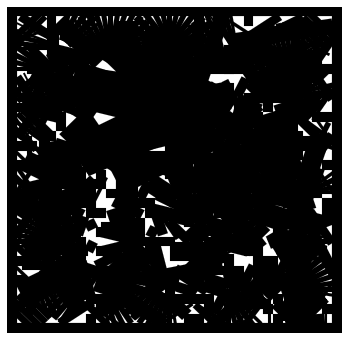

In [136]:
vordir_u2 = getCoverage(exp,vordir_G, directed = True)

In [137]:
results = [vordir_cost, vordir_ft, vordir_u1, vordir_u2, vordir_conmax, vordir_conavg, vordir_thres]
pd.DataFrame([results],columns=['cost','vordir_ft','vordir_u1','vordir_u2','vordir_max', 'vordir_avg','subgraph'])

,cost,vordir_ft,vordir_u1,vordir_u2,vordir_max,vordir_avg,subgraph
0,29.56003,27.106873,0.406638,0.570607,4.0,0.625,0.05


In [138]:
def showAccSolution(result_graph, paths, image, nodes, start_nodes, end_nodes, all_path = True, path_num = 0):
    edges_in_path = []
    image2 = 1-image
    fig, ax = plt.subplots(figsize=(12,12))
    img = np.array(1-image)
    ax = sb.heatmap(img)
    assigned = {}
    
    for index, path in enumerate(paths):
#         path = paths[path_num]
        for ite in range(len(path)-1):
            edges_in_path.append(np.array([path[ite],path[ite+1],0]))
            p1 = result_graph.nodes[path[ite]]['position']
            p2 = result_graph.nodes[path[ite+1]]['position']

            for r in (p1.x, p2.x, 1):
                for c in (p1.y, p2.y, 1):
                    if (Point(r,c) in np.array(nodes)[end_nodes]):
                        image2[int(r),int(c)] = 1
                    else:
                        image2[int(r),int(c)] += 0.2

        drawn = {}
        loop = result_graph.edges if all_path else edges_in_path

        for elem in loop:
            cur = result_graph.edges[elem[0], elem[1], 0]['probability']
            opposite = result_graph.edges[elem[1], elem[0], 0]['probability']
            unused = 1 - cur - opposite
            scaler = 0.7
            if cur > opposite:
                p1 = result_graph.nodes[elem[0]]['position']
                arr1 = np.array([p1.x,p1.y])
                p2 = result_graph.nodes[elem[1]]['position']
                arr2 = np.array([p2.x,p2.y])
                direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
                mag = np.linalg.norm(arr2 - arr1)*scaler
                dx, dy = mag*direction
            else:
                p1 = result_graph.nodes[elem[1]]['position']
                arr1 = np.array([p1.x,p1.y])
                p2 = result_graph.nodes[elem[0]]['position']
                arr2 = np.array([p2.x,p2.y])
                direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
                mag = np.linalg.norm(arr2 - arr1)*scaler
                dx, dy = mag*direction
            
            # only draw arrow once
            if frozenset((p1.y, p1.x, dy, dx)) not in assigned.keys():
                plt.arrow(p1.y, p1.x, dy, dx, head_width = 0.35, alpha=0.9, color = 'grey', linewidth=1)
                assigned[frozenset((p1.y, p1.x, dy, dx))] = 1
            
#         p = start_nodes[index]
#         plt.scatter(nodes[p].y, nodes[p].x, color = 'red', linewidths=5)
#         p = end_nodes[index]
#         plt.scatter(nodes[p].y, nodes[p].x, color = 'lime', linewidths=5)
#         name = './results/vordir_path'+ str(path_num)+'.png'
#         plt.gca().invert_yaxis()
#         plt.savefig(name)
        
    for p in start_nodes:
        plt.scatter(nodes[p].y, nodes[p].x, color = 'red', linewidths=5)
    for p in end_nodes:
        plt.scatter(nodes[p].y, nodes[p].x, color = 'lime', linewidths=5)

#     name = './data/'+ 'ANN' +'.png'
    plt.gca().invert_yaxis()
#     plt.savefig(name)
    return fig

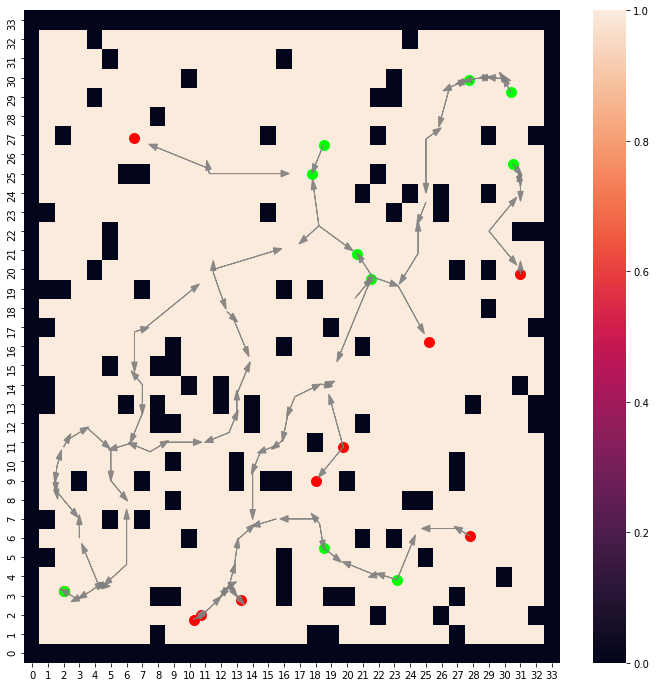

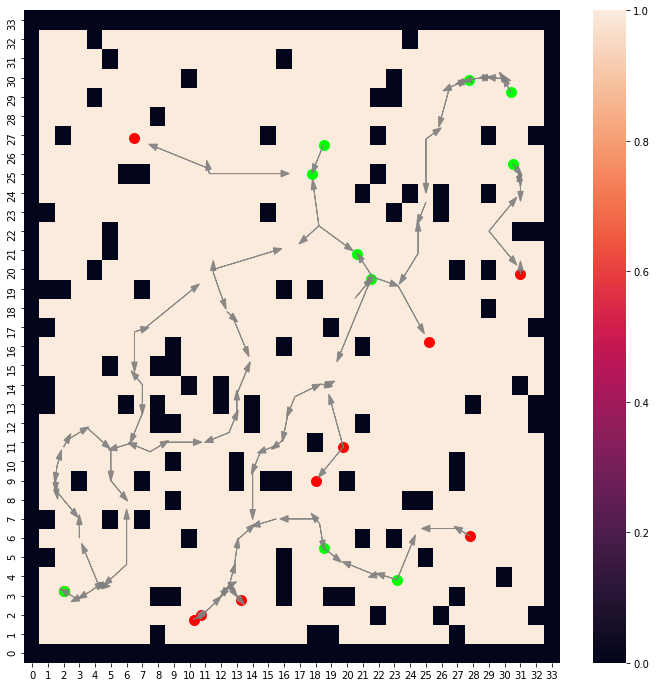

In [139]:
showAccSolution(vordir_G0, 
                vordir_paths, 
                exp.image, 
                exp.nodes, 
                exp.start_nodes, 
                exp.end_nodes, 
                all_path = False, 
                path_num = 0) #path_num variables is unused

In [90]:
# exp.occupancy_grid.original_values[:10, 25:30]

array([[1., 1., 1., 1., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [91]:
# exp.occupancy_grid._values[:10, 25:30]

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [83]:
# exp.end_locations

array([[29., 15.],
       [24., 28.],
       [ 2., 21.],
       [ 1., 31.],
       [32.,  1.],
       [ 2., 24.],
       [ 3., 28.],
       [ 5., 18.],
       [17., 20.],
       [12., 19.]])

In [104]:
# grid = np.array(
# [
#     [1,1,1,1,1],
#     [1,0,0,0,1],
#     [1,0,1,0,1],
#     [1,0,0,0,1],
#     [1,0,0,0,1],
#     [1,1,1,1,1],
# ]
# )



In [108]:
# from skimage.transform import resize
# from skimage import img_as_bool

# grid = np.array(grid, dtype=np.bool)
# transformed = img_as_bool(resize(grid, (10, 10)))
# transformed = transformed.astype(int)

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
       [1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])